# **0. Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import time
import os
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transform
from torchvision.utils import make_grid
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# **1. Data Loading**
**Open the data in the pandas table**

In [2]:
train_pd = pd.read_csv('../input/digit-recognizer/train.csv')
train_pd.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Now we know that there are only 10 classes from 0 to 9**

In [3]:
sorted(train_pd.label.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

**Let's see what the pictures look like**

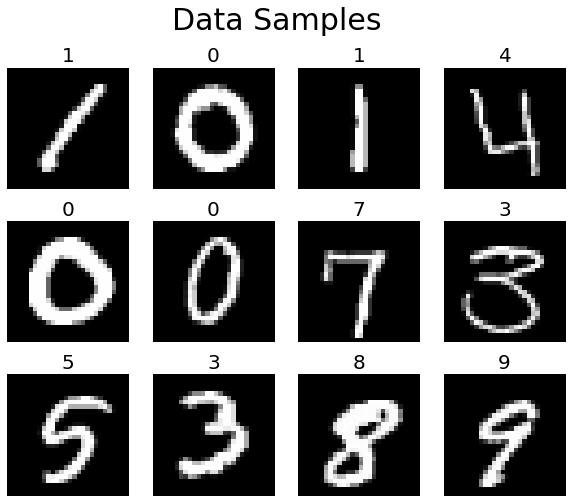

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,8))

i = 0
for row in range(3):
  for col in range(4):
    axs[row][col].imshow(train_pd.iloc[i, 1:].values.reshape(28,28), cmap='gray')
    axs[row][col].set_title(str(train_pd.iloc[i, 0]), fontsize=20)
    axs[row][col].axis('off')
    i+=1

plt.suptitle('Data Samples', fontsize=30)
plt.show()

# **2. Data preparation**

**Here we can see that there is no strong imbalance, so it is not worth fighting it**

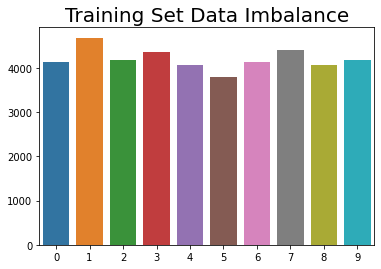

In [5]:
train_samplesize = pd.DataFrame({str(x): train_pd['label'].value_counts()[x] for x in range(10)}, index=[0])

sns.barplot(data=train_samplesize).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()

**Sometimes the data is normalized in advance, but as you can see in the graph, this is not the case, so the data will have to be normalized**

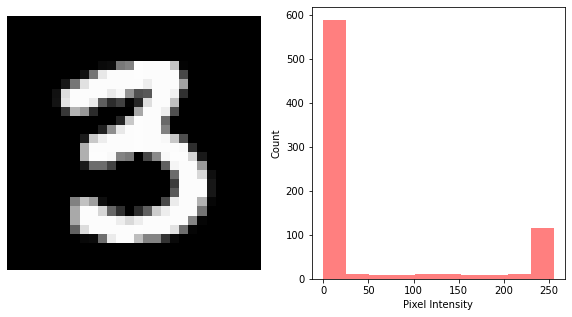

In [6]:
def plotHist(img):
  img = train_pd.iloc[img, 1:].values.reshape(28,28)
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, color='r', alpha=0.5)

plotHist(2021)

**Let's write our own dataset so that we can apply augmentations**

In [7]:
class MyDataset(Dataset):
  def __init__(self, features, labels, Transform):
    self.x = features
    self.y = labels
    self.transform = Transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.transform(self.x[index]), self.y[index]

**Before calling the class, you need to prepare the data, that is, break the dataframe into features and labels, make a reshape, and convert it to tensors. All this is done by the function below**

In [8]:
def GetDf(df, Transform):
  x_features = df.iloc[:, 1:].values
  y_labels = df.label.values
  x_features = x_features.reshape(-1, 1, 28, 28)
  x_features = np.uint8(x_features)
  x_features = torch.from_numpy(x_features)
  y_labels = torch.from_numpy(y_labels)
  return MyDataset(x_features, y_labels, Transform)

**Augmentation. There is nothing unusual here, I would just like to draw your attention to the fact that we are converting images to three-channel images, since they will be fed to the input models that were pre-trained on three-channel images**

In [9]:
transformer = {
 '0': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(94),
                           transform.Grayscale(num_output_channels=3), 
                           transform.ToTensor(),
                           transform.Normalize(
                                    [0.13097111880779266, 0.13097111880779266, 0.13097111880779266],
                                    [0.30848443508148193, 0.30848443508148193, 0.30848443508148193])
]),

    '1': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(94),
                           transform.Grayscale(num_output_channels=3),
                           transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transform.RandomRotation(5),
                           transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transform.ToTensor(),
                           transform.Normalize(
                                    [0.13097111880779266, 0.13097111880779266, 0.13097111880779266],
                                    [0.30848443508148193, 0.30848443508148193, 0.30848443508148193])
]),
    'val': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(94),
                           transform.Grayscale(num_output_channels=3),
                           transform.ToTensor(),
                           transform.Normalize(
                                  [0.13141274452209473, 0.13141274452209473, 0.13141274452209473],
                                  [0.30904173851013184, 0.30904173851013184, 0.30904173851013184])
    ])
}

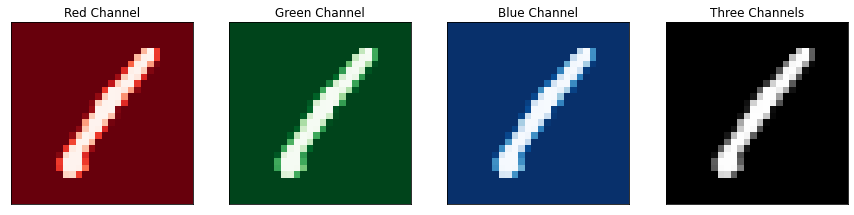

In [10]:
exampleset = GetDf(train_pd, Transform=transform.Compose([
                           transform.ToPILImage(),
                           transform.Grayscale(num_output_channels=3),
                           transform.ToTensor()
    ]))

x, y = next(iter(torch.utils.data.DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0), cmap='gray')
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

# **3. Training and Test**
**I will use an ensemble of pre-trained models, the idea is this: I first train only the classifier on 10 epochs, then unfreeze the network and train all together for another 10 epochs. After that, the model makes predictions on the test data**

In [11]:
# Get the device
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


**This is a custom dataset for the test part of the data**

In [12]:
class TestDataset(Dataset):
    def __init__(self, features,transform=transform.Compose([
                              transform.ToPILImage(),
        transform.Resize(94),
        transform.Grayscale(num_output_channels=3),
                              transform.ToTensor(),
                              transform.Normalize(
                                  [0.13141274452209473, 0.13141274452209473, 0.13141274452209473],
                                  [0.30904173851013184, 0.30904173851013184, 0.30904173851013184])
    ])):
        self.features = features.values.reshape((-1,28,28)).astype(np.uint8)
        self.targets = None
        self.transform=transform
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return self.transform(self.features[idx])

**Let's write a function that will create its own datasets for each model**

In [13]:
def create_dataloaders(seed, test_size=0.1, df=train_pd, batch_size=50):
    
    # Create training set and validation set
    train_data, valid_data = train_test_split(df,
                                              test_size=test_size,
                                              random_state=seed)
    
    # Create Datasets
    train_dataset_0 = GetDf(train_data, Transform=transformer['0'])
    train_dataset_1 = GetDf(train_data, Transform=transformer['1'])
    
    train_dataset = ConcatDataset([train_dataset_0, train_dataset_1])

    valid_dataset = GetDf(valid_data, Transform=transformer['val'])
    
    # Create Dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)

    train_size = len(train_dataset)
    val_size = len(valid_dataset)

    return train_loader, valid_loader, train_size, val_size

**Here we will save the history to make a visualization at the end**

In [14]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Train function structure:

1. **Classifier Training**
1. **Network-wide Training**
1. **Predictions**

In [15]:
def train(seed, epochs, model):

  # Train and valid dataloaders
  print('Creating new dataloaders...')
    
  train_loader, valid_loader, train_size, val_size = create_dataloaders(seed=seed)

  loaders = {'train': train_loader, 'val': valid_loader}

  dataset_sizes = {'train': train_size, 'val': val_size}

  print('Creating a model {}...'.format(seed))

  model.to(device)  
  criterion = nn.CrossEntropyLoss()
  if seed==2 or seed==3:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
            

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

#       if phase == 'train':
#           acc = 100. * running_corrects.double() / dataset_sizes[phase]
#           scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)


  model.load_state_dict(best_model)

  for param in model.parameters():
        param.requires_grad=True

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
#   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

#       if phase == 'train':
#         acc = 100. * running_corrects.double() / dataset_sizes[phase]
#         scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step() 
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

  model.load_state_dict(best_model)
    
  model.eval() # Evaluation mode -> Turn off dropout
  test_pred = torch.LongTensor()
    
  if use_cuda:
    test_pred = test_pred.cuda()
        
  with torch.no_grad(): # Turn off gradients for prediction, saves memory and computations
    for features in test_loader:
        
        if use_cuda:
            features = features.cuda()

            # Get the softmax probabilities
        outputs = model(features)
            # Get the prediction of the batch
        _, predicted = torch.max(outputs, 1)
            # Concatenate the prediction
        test_pred = torch.cat((test_pred, predicted), dim=0)
    
  model_name = 'model_' + str(seed + 1)
  ensemble_df[model_name] = test_pred.cpu().numpy()
  print('Prediction Saved! \n') 

**Uploading models**

In [16]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=10, bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [17]:
densenet121_1 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_1.parameters():
  param.requires_grad=False

densenet121_1.classifier = nn.Linear(in_features=densenet121_1.classifier.in_features, out_features=10, bias=True)

In [18]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=10, bias=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [19]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=10, bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [20]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, 10, bias=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

**Launching training**

In [21]:
# Create test_loader
submit_df = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
test_df = pd.read_csv('../input/digit-recognizer/test.csv')
test_dataset = TestDataset(test_df)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

ensemble_df = submit_df.copy()

num_models = 5
num_epochs = 10

models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
   train(seed=seed, epochs=num_epochs, model=models[seed])

Creating new dataloaders...
Creating a model 0...
Epoch: 1/10
train - loss:0.594278844526757, accuracy0.8144179894179895
val - loss:0.30239479181667167, accuracy0.9052380952380953
Time: 2.0m 26.784544944763184s
Epoch: 2/10
train - loss:0.4449986136966833, accuracy0.856468253968254
val - loss:0.27218970230647493, accuracy0.9166666666666666
Time: 4.0m 53.479334354400635s
Epoch: 3/10
train - loss:0.41664718590657074, accuracy0.8640343915343915
val - loss:0.25908183492720127, accuracy0.919047619047619
Time: 7.0m 20.67516255378723s
Epoch: 4/10
train - loss:0.40531864460735095, accuracy0.8696560846560847
val - loss:0.25747311177353066, accuracy0.9254761904761905
Time: 9.0m 50.79723072052002s
Epoch: 5/10
train - loss:0.37775013374076005, accuracy0.8776058201058201
val - loss:0.23858449732263884, accuracy0.9278571428571428
Time: 12.0m 19.62287163734436s
Epoch: 6/10
train - loss:0.3715468186825987, accuracy0.8792195767195767
val - loss:0.23594613861115205, accuracy0.9295238095238095
Time: 14.0m

# **4. Submit Preparing**

In [22]:
ensemble_df.head()

,ImageId,Label,model_1,model_2,model_3,model_4,model_5
0,1,0,2,2,2,2,2
1,2,0,0,0,0,0,0
2,3,0,9,9,9,9,9
3,4,0,0,0,0,0,0
4,5,0,3,3,3,3,3


In [23]:
# Final prediction
final_pred = ensemble_df.iloc[:,2:].mode(axis=1).iloc[:,0]
submit_df.Label = final_pred.astype(int)
submit_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [24]:
# Create a submission file
submit_df.to_csv('submission0.csv', index=False)

# **5. Learning Visualization**

**As you can see, the idea of defrosting feature extractor worked and we see a sharp increase in accuracy**

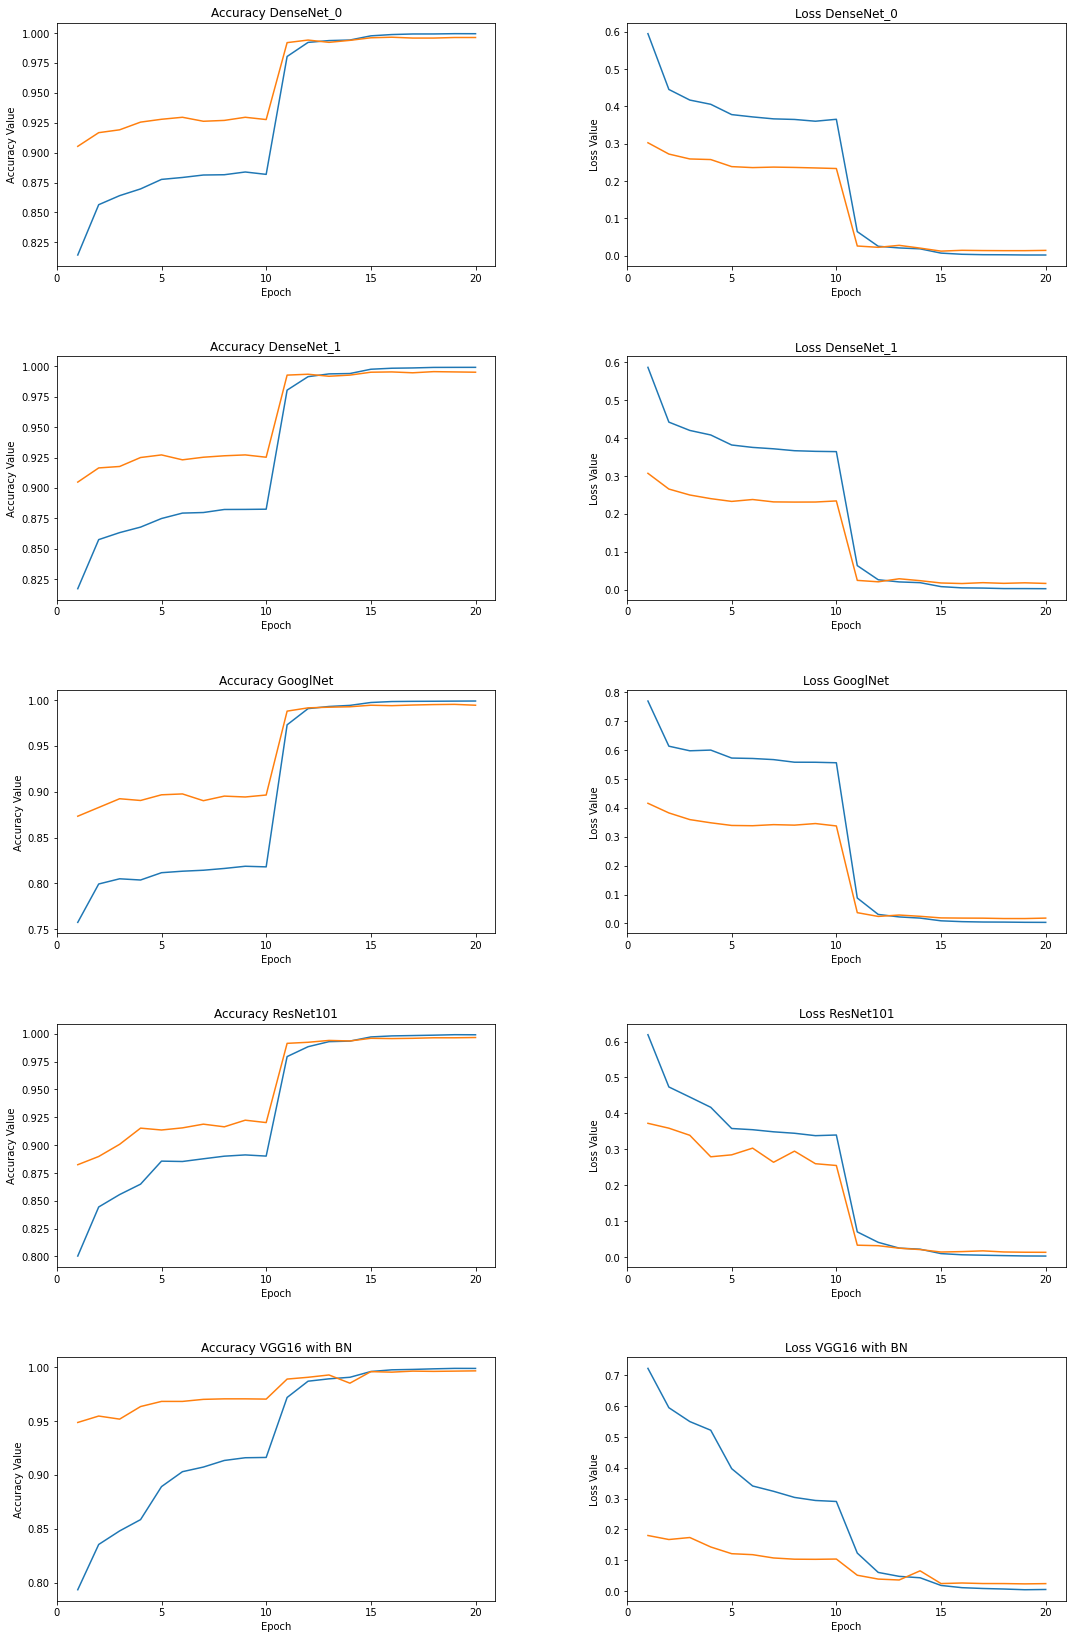

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
modelname = ['DenseNet_0', 'DenseNet_1', 'GooglNet', 'ResNet101', 'VGG16 with BN']

epochs=10

i=0

for row in range(5):

  epoch_list = list(range(1,epochs*2+1))

  ax[row][0].plot(epoch_list, accuracies['train'][i:20+i], label='Train Accuracy')
  ax[row][0].plot(epoch_list, accuracies['val'][i:20+i], label='Validation Accuracy')
  ax[row][0].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][0].set_ylabel('Accuracy Value')
  ax[row][0].set_xlabel('Epoch')
  ax[row][0].set_title('Accuracy {}'.format(modelname[row]))

  ax[row][1].plot(epoch_list, losses['train'][i:20+i], label='Train Loss')
  ax[row][1].plot(epoch_list, losses['val'][i:20+i], label='Validation Loss')
  ax[row][1].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][1].set_ylabel('Loss Value')
  ax[row][1].set_xlabel('Epoch')
  ax[row][1].set_title('Loss {}'.format(modelname[row]))
  fig.tight_layout()
  fig.subplots_adjust(top=1.5, wspace=0.3)
  i+=20

***I am always happy to receive any feedback. What do you think can be changed and what can be removed?***